# Imports

In [6]:
# local imports
from scripts.data import generate_random_simulation, generate_features, SimulationData, save_result, load_result
from scripts.nn import create_autoencoder_model, train_encoder, train_encoder_with_constraints
from scripts.loss import recovery_loss, fixed_points_loss, subsequent_distances_loss, angle_differences_loss, imu_loss, angle_change_loss
from scripts.visualization import plot_loss_evolution, plot_multiloss_evolution, plot_embedding,plot_embedding_on_simulation, plot_embedding_pca, merge_losses

# pytorch
import torch
from torch import optim
from torch import nn
from torch.nn.functional import mse_loss, relu

# data manipulation
import numpy as np
from os.path import join, exists
from os import mkdir
import tqdm

# visualization
from matplotlib import pyplot as plt

(-2, 3)

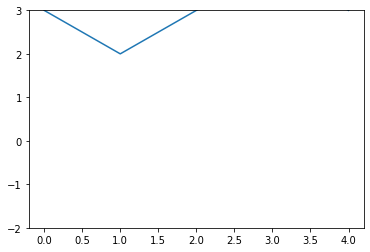

In [16]:
plt.plot([3,2,3,4,3])
plt.ylim([-2,3])

In [2]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# Setup

## Parameters

### Data

In [17]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

DATA_PATH = 'data/'
SIMULATIONS_FILE_NAME = join(DATA_PATH, 'generated_simulations.pt')
ANCHORS_FILE_NAME = join(DATA_PATH, 'anchors_pos.pt')
CAL_FILE_NAME = join(DATA_PATH, 'calibration_data')

### Neural network

In [4]:
BATCH_SIZE = 1
N_EPOCHS = 500

## Load simulations

In [5]:
simulations = torch.load(SIMULATIONS_FILE_NAME)
anchors_pos = torch.load(ANCHORS_FILE_NAME)
data = SimulationData(simulations, anchors_pos)

In [22]:
len(data[:20][1])

20

# Generate calibration data

## Generate

In [6]:
def rand_uniform(*size, min_=0, max_=1):
    return torch.rand(size) * (max_ - min_) + min_

In [7]:
def generate_calibration_data(n_sims, n_samples, x_bounds, y_bounds):
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds

    # generate horizontal calibration data
    fixed_ys = rand_uniform(n_sims, min_=y_min, max_=y_max)
    fixed_ys = fixed_ys[:, None].repeat(1, n_samples)
    random_xs = rand_uniform(n_sims, n_samples, min_=x_min, max_=x_max)
    horizontal_sims = torch.stack((random_xs, fixed_ys), 2)
    
    # generate vertical calibration data
    fixed_xs = rand_uniform(n_sims, min_=x_min, max_=x_max)
    fixed_xs = fixed_xs[:, None].repeat(1, n_samples)
    random_ys = rand_uniform(n_sims, n_samples, min_=y_min, max_=y_max)
    vertical_sims = torch.stack((fixed_xs, random_ys), 2)
    
    return horizontal_sims, vertical_sims

In [9]:
horizontal_sims, vertical_sims = generate_calibration_data(100, N_STEPS, [MIN_X, MAX_X], [MIN_Y, MAX_Y])

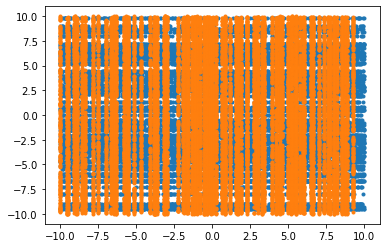

In [10]:
plt.plot(*horizontal_sims.view(-1, 2).t(), '.')
plt.plot(*vertical_sims.view(-1, 2).t(), '.')

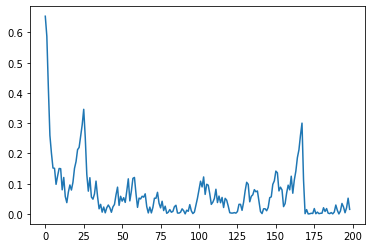

In [24]:
dirs = data[5][1]
plt.plot((dirs[1:] - dirs[:-1]).pow(2).sum(1))

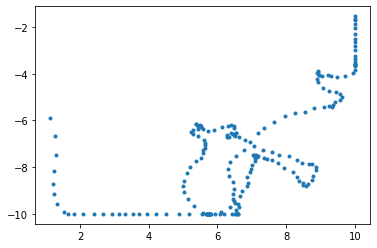

In [36]:
plt.plot(*data[10][1].T, '.')

## Save

In [106]:
torch.save([horizontal_sims, vertical_sims], CAL_FILE_NAME)

## Load

In [52]:
horizontal_sims, vertical_sims = torch.load(CAL_FILE_NAME)

## Transform into dataset

In [11]:
horizontal_cal_data = SimulationData(horizontal_sims, anchors_pos)
vertical_cal_data = SimulationData(vertical_sims, anchors_pos)

# Training

## training functions

In [12]:
def train(model, iterator, optimizer, criterion):
    total_loss = 0
    
    for batch_input, batch_target in iterator:
        source = batch_input.view(-1, batch_input.size(-1))
        decoded = model(source)

        loss = criterion(decoded, source)

        optimizer.zero_grad() # set gradients to zero
        loss.backward() # compute gradient
        optimizer.step() # update weights
        total_loss += loss.item()
    return total_loss / len(iterator)

def evaluate(model, iterator, optimizer, criterion):
    total_loss = 0
    
    for batch_input, batch_target in iterator:
        source = batch_input.view(-1, batch_input.size(-1))
        decoded = model(source)

        loss = criterion(decoded, source)
        total_loss += loss.item()
    return total_loss / len(iterator)

In [13]:
def successive_inequality_error(x):
    return mse_loss(x[1:], x[:-1])

In [1]:
def train_calibration(encoder, horizontal_cal_data, vertical_cal_data, optimizer):
    total_loss = 0
    
    for batch_src, _ in horizontal_cal_data:
        source = batch_src.view(-1, batch_src.size(-1))
        encoded = encoder(source)

        loss = 100 * successive_inequality_error(encoded[:, 1])

        optimizer.zero_grad() # set gradients to zero
        loss.backward() # compute gradient
        optimizer.step() # update weights
        total_loss += loss.item()
    
    for batch_src, _ in vertical_cal_data:
        source = batch_src.view(-1, batch_src.size(-1))
        encoded = encoder(source)

        loss = 100 * successive_inequality_error(encoded[:, 0])

        optimizer.zero_grad() # set gradients to zero
        loss.backward() # compute gradient
        optimizer.step() # update weights
        total_loss += loss.item()
        
    return total_loss / (len(horizontal_cal_data) + len(vertical_cal_data))

In [25]:
def train_encoder_with_cal(model, train_loader, test_loader, horizontal_cal_data, vertical_cal_data, nb_epochs, optimizer, criterion=nn.MSELoss()):
    """Train a model"""

    train_loss = {
        'recovery_loss': [],
        'calibration_loss': []
    }
    test_loss = {
        'recovery_loss': [],
        'calibration_loss': []
    }

    encoder, decoder = model

    for _ in tqdm.tqdm(range(nb_epochs)):
        # 
        train_recovery_loss = train(model, train_loader, optimizer, criterion)
        train_loss['recovery_loss'].append(train_recovery_loss)
        
        cal_loss = train_calibration(encoder, horizontal_cal_data, vertical_cal_data, optimizer)
        train_loss['calibration_loss'].append(cal_loss)
        
        test_recovery_loss = evaluate(model, test_loader, optimizer, criterion)
        test_loss['recovery_loss'].append(test_recovery_loss)

    return train_loss, test_loss

## Setup

In [26]:
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)
input_dim = 3 * N_ANCHORS
bot_dim = 2
hid_dim = 12

## Train

In [32]:
model = create_autoencoder_model(input_dim, hid_dim, bot_dim)

In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss, test_loss = train_encoder_with_cal(model, train_loader, test_loader,
                                               horizontal_cal_data, vertical_cal_data,
                                               5000, optimizer)

100%|██████████| 5000/5000 [20:02<00:00,  4.16it/s]


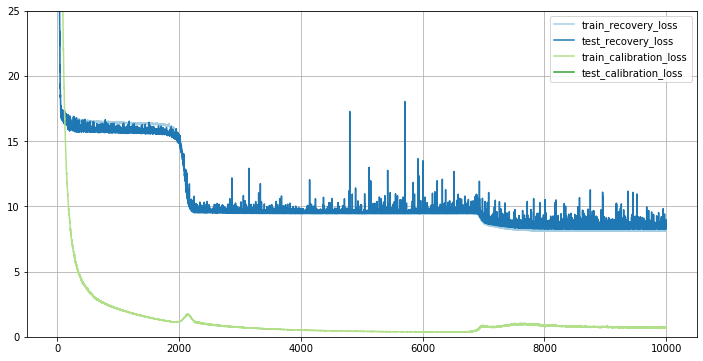

In [34]:
plot_multiloss_evolution(train_loss, test_loss, [0,25])

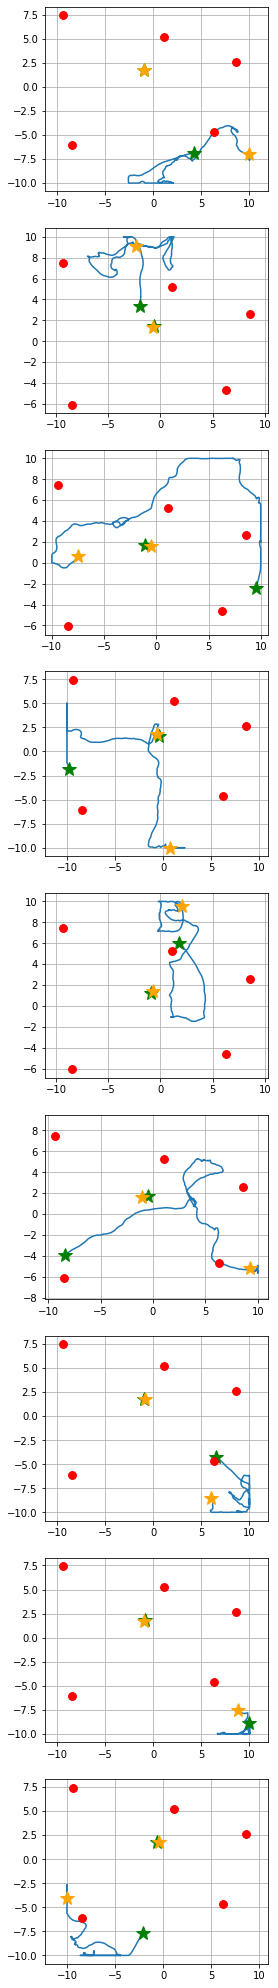

In [35]:
plot_embedding_on_simulation(model[0], data, range(9))